# Azure LLM inference traces
The trace description can be found [here](https://github.com/Azure/AzurePublicDataset/blob/master/AzureLLMInferenceDataset2024.md).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
TRACE_NAMES = [
    "Coding",
    "Conversation",
]

In [3]:
TRACE_FILENAMES = [
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv",
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv",
]

In [5]:
# Read all traces
df_traces = {}
for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
    # We need to use mixed format because we have both:
    # 2024-05-12 00:00:00.001163+00:00 and 2024-05-12 00:00:00+00:00
    # This is pretty expensive and there are probably better ways to handle this
    df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)

In [6]:
df_traces["Coding"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-10 00:00:00.009930+00:00,2162,5
1,2024-05-10 00:00:00.017335+00:00,2399,6
2,2024-05-10 00:00:00.022314+00:00,76,15
3,2024-05-10 00:00:00.037845+00:00,2376,1
4,2024-05-10 00:00:00.083890+00:00,7670,8
...,...,...,...
16803690,2024-05-16 23:59:59.886489+00:00,897,1
16803691,2024-05-16 23:59:59.925267+00:00,2842,79
16803692,2024-05-16 23:59:59.928444+00:00,378,56
16803693,2024-05-16 23:59:59.928698+00:00,491,1


In [7]:
df_traces["Conversation"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00.001163+00:00,1452,3
1,2024-05-12 00:00:00.041683+00:00,584,3
2,2024-05-12 00:00:00.157988+00:00,862,38
3,2024-05-12 00:00:00.158932+00:00,1569,3
4,2024-05-12 00:00:00.248279+00:00,617,104
...,...,...,...
27303994,2024-05-18 23:59:59.759803+00:00,1224,11
27303995,2024-05-18 23:59:59.790078+00:00,283,56
27303996,2024-05-18 23:59:59.909045+00:00,336,8
27303997,2024-05-18 23:59:59.925224+00:00,3152,264


Coding


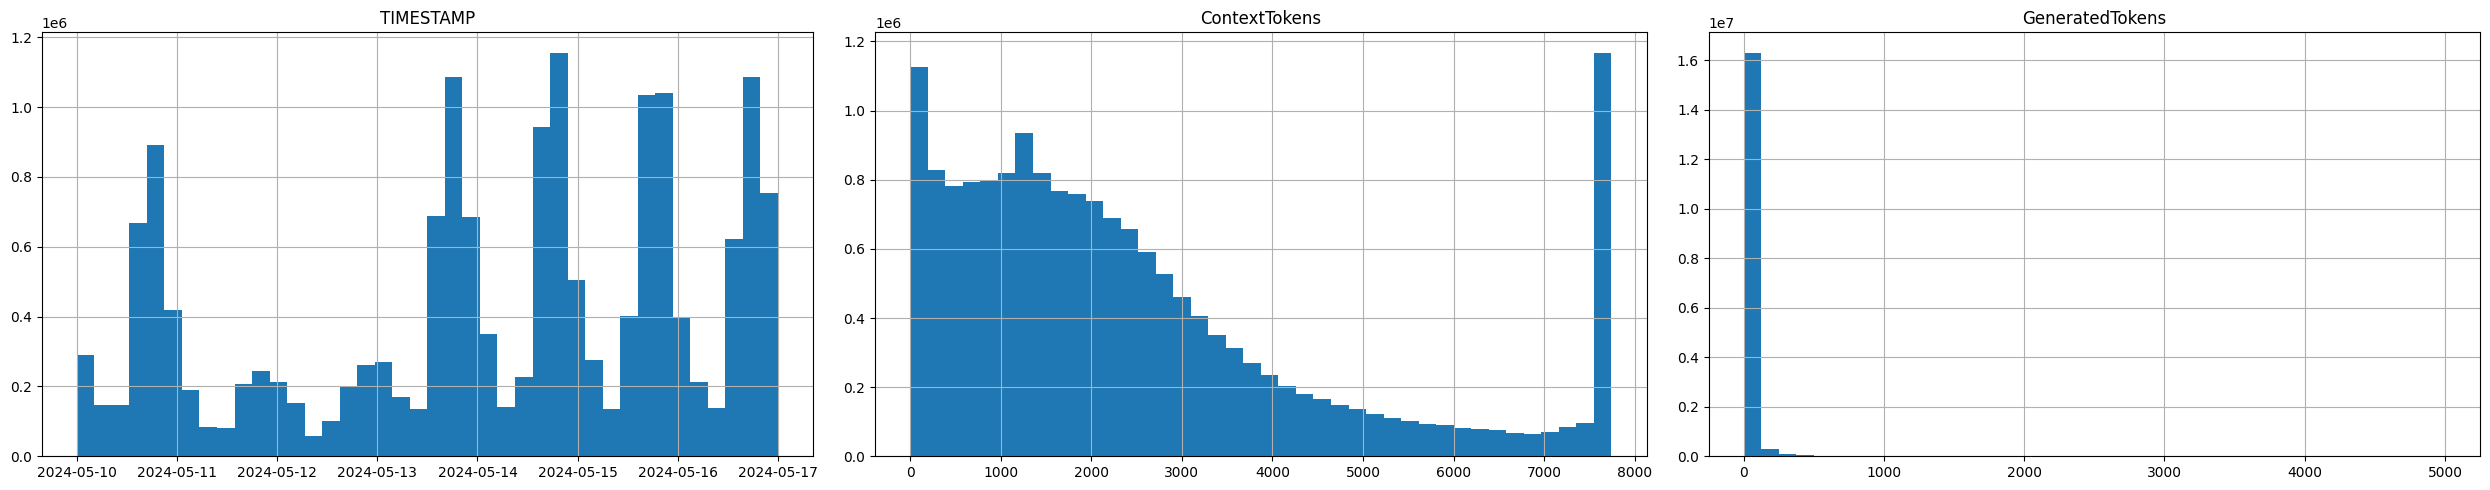

Conversation


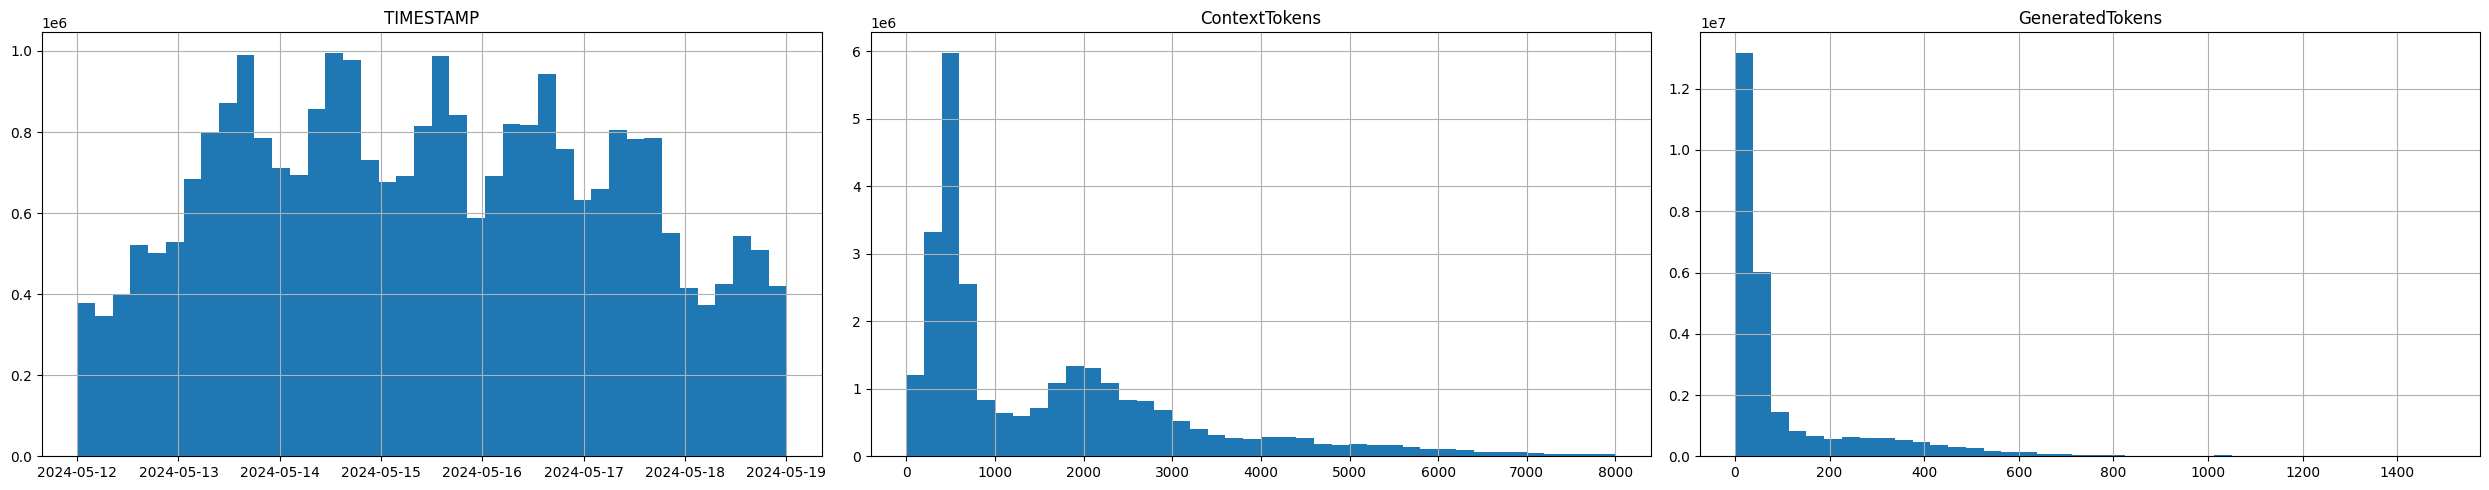

In [8]:
for trace_name, df_trace in df_traces.items():
    print(trace_name)
    df_trace.hist(
        layout=(1, 3),
        figsize=(25, 5),
        bins=40,
    )
    plt.tight_layout()
    plt.show()

## Token distributions

In [9]:
def get_cdf(df, field):
    vals = sorted(df[field].values)
    invs = 100.0 * np.arange(0, len(df)) / len(df)
    return vals, invs

In [10]:
def plt_tokens(dfs, field="ContextTokens", title="Input Tokens"):
    for df_key, df in dfs.items():
        df_tokens, df_inv = get_cdf(df, field)
        plt.plot(df_tokens, df_inv, label=df_key)
    plt.title(title)
    plt.ylabel("CDF")
    plt.xlabel("Number of tokens")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

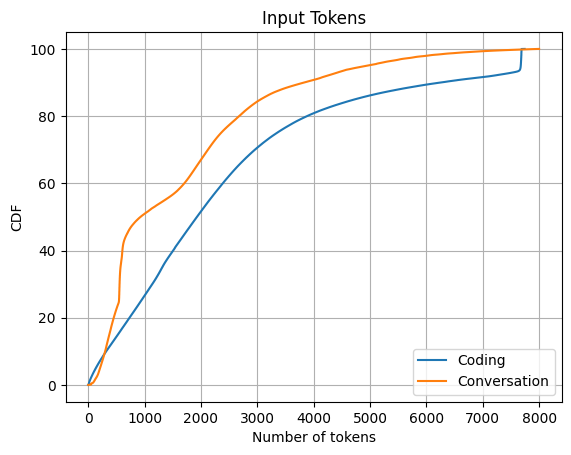

In [11]:
plt_tokens(df_traces, "ContextTokens", "Input Tokens")

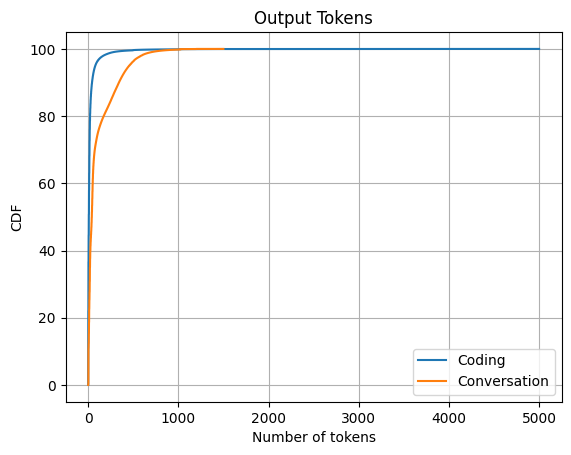

In [12]:
plt_tokens(df_traces, "GeneratedTokens", "Output Tokens")

## Correlation

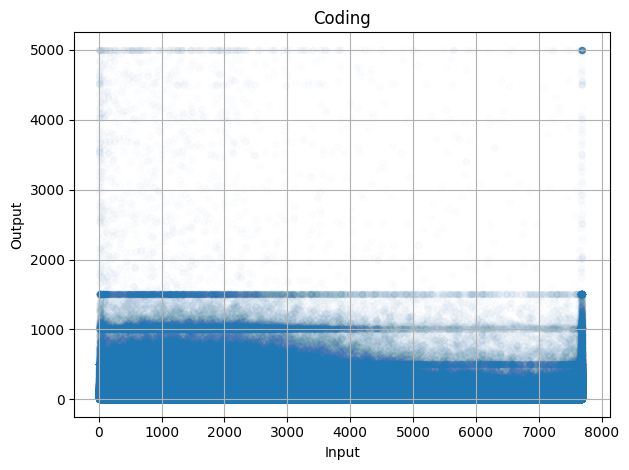

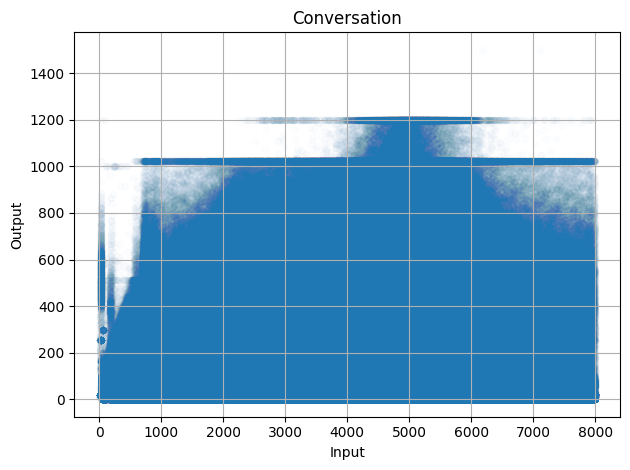

In [13]:
for trace_name, df_trace in df_traces.items():
    df_trace[["ContextTokens", "GeneratedTokens"]].plot.scatter(
        x="ContextTokens",
        y="GeneratedTokens",
        xlabel="Input",
        ylabel="Output",
        alpha=0.01,
        grid=True,
        title=trace_name,
    )
    plt.tight_layout()
    plt.show()

## Analysis over time

In [14]:
def plt_invocations_time(df, figsize=(15, 5)):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy.groupby("Time").count()["TIMESTAMP"].plot(
        grid=True,
        ylim=0,
        figsize=figsize
    )
    plt.ylabel("Number of invocations per minute")
    plt.tight_layout()
    plt.show()

In [15]:
def plt_tokens_time(df, field="ContextTokens", label="Input", show=False):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy[["Time", field]].groupby("Time").sum()[field].plot(
        grid=True,
        ylim=0,
        label=label,
    )
    plt.ylabel("Number of tokens per minute")
    plt.legend()
    if show:
        plt.show()

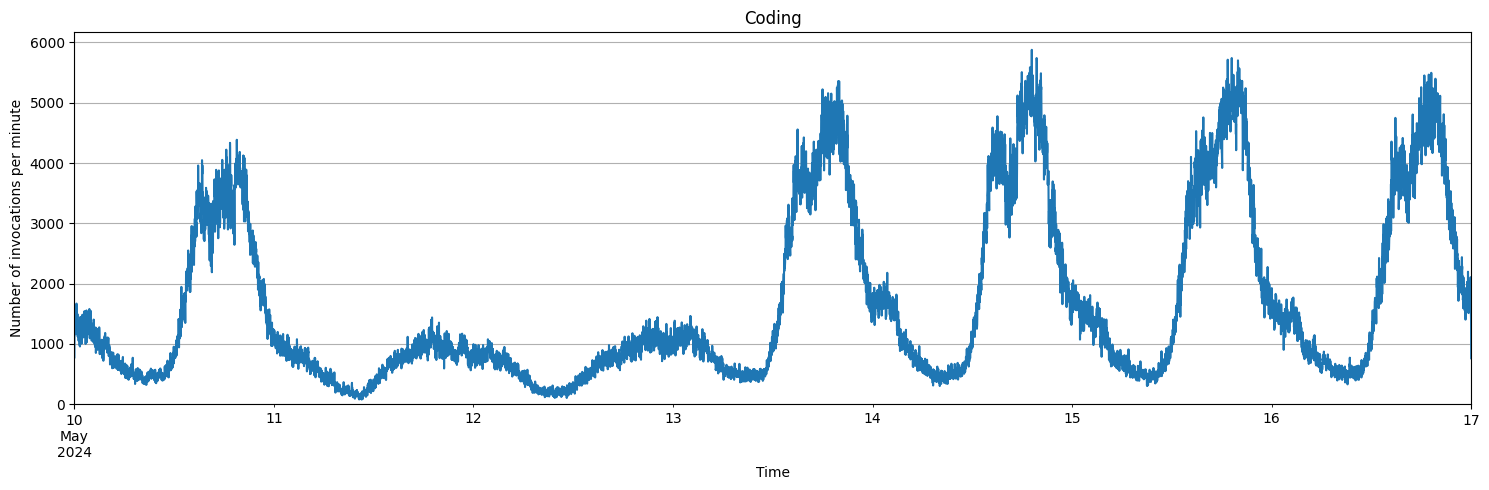

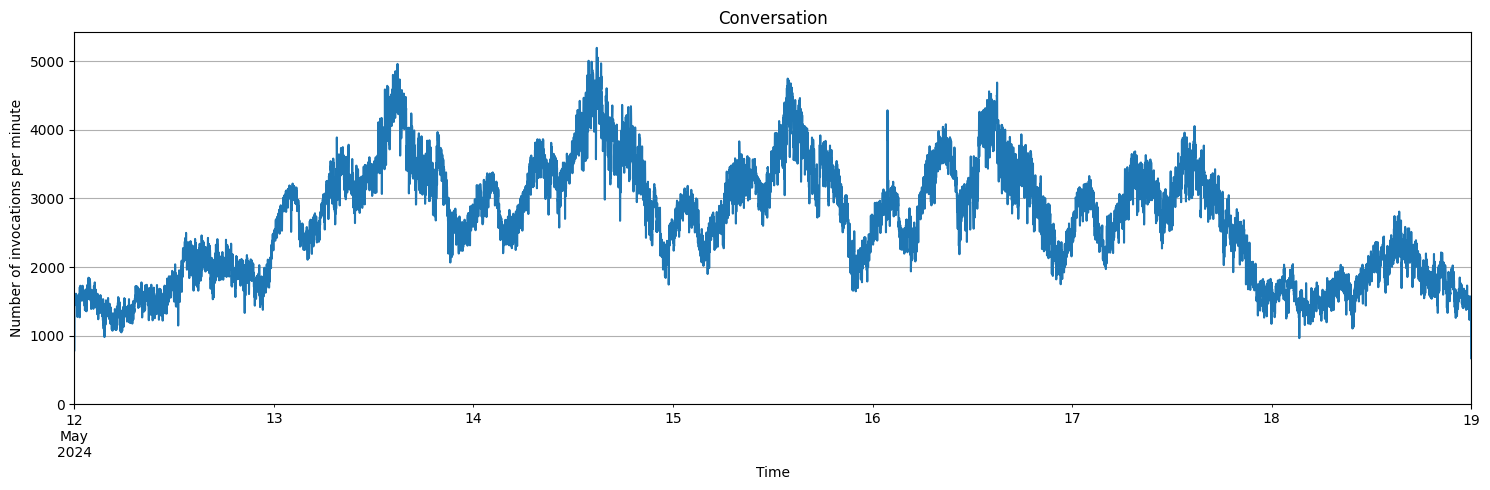

In [16]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_invocations_time(df_trace)

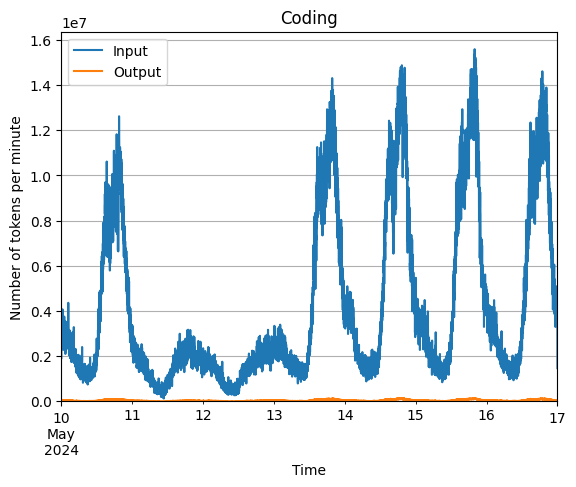

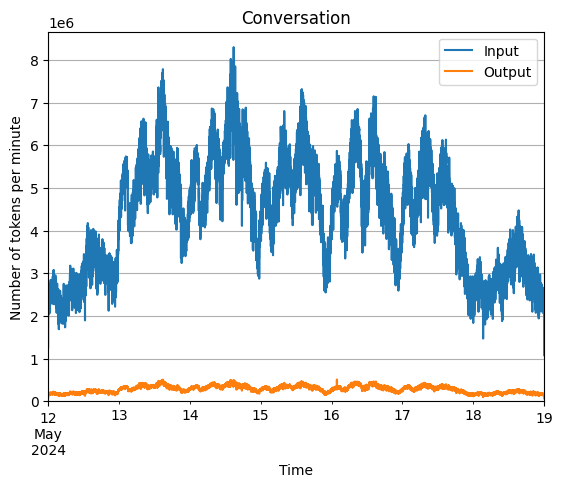

In [17]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_tokens_time(df_trace, "ContextTokens", "Input")
    plt_tokens_time(df_trace, "GeneratedTokens", "Output")
    plt.show()